In [41]:
import os
import warnings
from pathlib import Path
from dataclasses import dataclass

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint, LearningRateMonitor

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error , root_mean_squared_error

from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.data import GroupNormalizer, NaNLabelEncoder
from pytorch_forecasting.metrics import QuantileLoss, MAE

from lightning.pytorch.loggers import CSVLogger, TensorBoardLogger

In [ ]:
DATA_CSV = Path("D:\PSU/241-353/Mini_Project/data/augmented_data.csv")  # ensure this CSV is in the same folder when running
DATE_COL = "‡∏ß‡∏±‡∏ô‡∏ó‡∏µ‡πà"
TARGET_COL = "‡∏£‡∏ñ‡πÑ‡∏ü‡∏ü‡πâ‡∏≤ ARL"

# Exogenous covariates (adjust names if different in your CSV)
DAY_TYPE_COL = "day_type"         # categorical
RAIN_COL     = "rain_average"     # real
ARL_COL      = "‡∏£‡∏ñ‡πÑ‡∏ü‡∏ü‡πâ‡∏≤‡∏™‡∏≤‡∏¢‡∏™‡∏µ‡∏°‡πà‡∏ß‡∏á"      # real
PURPLE_COL   = "‡∏£‡∏ñ‡πÑ‡∏ü‡∏ü‡πâ‡∏≤‡∏™‡∏≤‡∏¢‡∏™‡∏µ‡∏ô‡πâ‡∏≥‡πÄ‡∏á‡∏¥‡∏ô" # real
BTS_COL      = "‡∏£‡∏ñ‡πÑ‡∏ü‡∏ü‡πâ‡∏≤ BTS"      # real

# Model / dataset params
GROUP_ID = "series_id"
MAX_PRED_LEN = 30
MAX_ENC_LEN  = 120
BATCH_SIZE_TRAIN = 64
BATCH_SIZE_EVAL  = 128
EPOCHS = 200
LR = 3e-4
RANDOM_SEED = 2025

In [68]:
PLOTS_DIR = Path("tft_arl_outputs")
PLOTS_DIR.mkdir(exist_ok=True, parents=True)
csv_logger = CSVLogger(save_dir=str(PLOTS_DIR), name="logs")

In [69]:
def _safe_interp_fill(s: pd.Series) -> pd.Series:
    """Interpolate then back/forward fill for numeric series."""
    try:
        s = pd.to_numeric(s, errors="coerce")
    except Exception:
        pass
    s = s.interpolate(limit_direction="both")
    s = s.bfill().ffill()
    return s

In [70]:

pl.seed_everything(RANDOM_SEED, workers=True)
warnings.filterwarnings("ignore")

# 1) Load data
if not DATA_CSV.exists():
    raise FileNotFoundError(f"CSV not found: {DATA_CSV.resolve()}")
df = pd.read_csv(DATA_CSV)

# Basic checks
for c in [DATE_COL, TARGET_COL]:
    if c not in df.columns:
        raise ValueError(f"Column '{c}' not found in CSV. Please edit config at top of the file.")

# 2) Feature engineering
df[DATE_COL] = pd.to_datetime(df[DATE_COL])
df = df.sort_values(DATE_COL).reset_index(drop=True)
df[GROUP_ID] = "blue"
df["time_idx"] = (df[DATE_COL] - df[DATE_COL].min()).dt.days.astype(int)

# Optional: build is_weekend from date (Saturday=5, Sunday=6)
# df["is_weekend"] = df[DATE_COL].dt.weekday.isin([5, 6]).astype(int)
df["dow"] = df[DATE_COL].dt.weekday.astype("category")
# Cast categorical for day_type if present
if DAY_TYPE_COL in df.columns:
    df[DAY_TYPE_COL] = df[DAY_TYPE_COL].astype(str).astype("category")

if "dow" in df.columns:
    df["dow"] = df["dow"].astype(str).astype("category")

# Fill numeric covariates
for col in [RAIN_COL, ARL_COL, PURPLE_COL, BTS_COL, TARGET_COL]:
    if col in df.columns:
        df[col] = _safe_interp_fill(df[col])

# 3) Define feature lists (no leakage: do NOT include target in features)
time_varying_known_categoricals = [c for c in [DAY_TYPE_COL, "dow"] if c in df.columns]
time_varying_known_reals = ["time_idx"]

categorical_encoders = {}
if DAY_TYPE_COL in df.columns:
    categorical_encoders[DAY_TYPE_COL] = NaNLabelEncoder(add_nan=True)  # ‡πÄ‡∏ú‡∏∑‡πà‡∏≠‡∏°‡∏µ‡∏Ñ‡πà‡∏≤‡∏ß‡πà‡∏≤‡∏á/‡πÑ‡∏°‡πà‡∏£‡∏π‡πâ‡∏•‡πà‡∏ß‡∏á‡∏´‡∏ô‡πâ‡∏≤
if "dow" in df.columns:
    categorical_encoders["dow"] = NaNLabelEncoder(add_nan=False)     

time_varying_unknown_reals = []
for col in [ARL_COL, BTS_COL, PURPLE_COL, RAIN_COL]:
    if col in df.columns:
        time_varying_unknown_reals.append(col)

# 4) Split by time for training/validation
max_time_idx = int(df["time_idx"].max())
training_cutoff = max_time_idx - MAX_PRED_LEN

Seed set to 2025


In [71]:
max_time_idx

2072

In [72]:
training_cutoff

2042

In [73]:
# Training dataset
training = TimeSeriesDataSet(
    df[df.time_idx <= training_cutoff],
    time_idx="time_idx",
    target=TARGET_COL,
    group_ids=[GROUP_ID],
    max_encoder_length=MAX_ENC_LEN,
    max_prediction_length=MAX_PRED_LEN,
    target_normalizer=GroupNormalizer(groups=[GROUP_ID], transformation=None),  # keep target in original scale
    static_categoricals=[GROUP_ID],
    time_varying_known_categoricals=time_varying_known_categoricals,
    time_varying_known_reals=time_varying_known_reals,
    time_varying_unknown_reals=time_varying_unknown_reals + [TARGET_COL],  # include target as unknown-real (historical known to encoder, masked in decoder)
    add_relative_time_idx=True,
    add_encoder_length=True,
    add_target_scales=True,
    categorical_encoders=categorical_encoders
)


# Validation FUTURE (predict next 30 days) -> no y_true
val_future = TimeSeriesDataSet.from_dataset(training, df, predict=True, stop_randomization=True)



In [74]:
# Validation HISTORICAL window that still has y_true (backtest)
start_idx = int(training_cutoff - MAX_ENC_LEN - MAX_PRED_LEN + 1)
end_idx   = int(training_cutoff)
mask = (df["time_idx"] >= start_idx) & (df["time_idx"] <= end_idx)
df_val_hist = df.loc[mask].copy()
needed = MAX_ENC_LEN + MAX_PRED_LEN
if len(df_val_hist) < needed:
    # fallback: shrink encoder length to fit
    shrink = needed - len(df_val_hist) + 1
    enc_len = max(30, MAX_ENC_LEN - shrink)  # don't go below 30
    print(f"[WARN] val_hist window too short ({len(df_val_hist)} rows). Shrinking encoder length to {enc_len}.")
    enc_len_use = enc_len
else:
    enc_len_use = MAX_ENC_LEN


In [75]:
# 5) Dataloaders
train_loader = training.to_dataloader(train=True,  batch_size=BATCH_SIZE_TRAIN, num_workers=0)
val_loader   = val_future.to_dataloader(train=False, batch_size=BATCH_SIZE_EVAL, num_workers=0)


In [76]:
# ‡πÅ‡∏Å‡πâ‡πÑ‡∏Ç‡πÇ‡∏Ñ‡πâ‡∏î‡πÉ‡∏´‡πâ validation ‡πÅ‡∏•‡∏∞ test ‡πÄ‡∏õ‡πá‡∏ô‡∏ä‡πà‡∏ß‡∏á‡πÄ‡∏î‡∏µ‡∏¢‡∏ß‡∏Å‡∏±‡∏ô
val_start_idx = training_cutoff + 1      # 2043 
val_end_idx = training_cutoff + MAX_PRED_LEN  # 2072

print(f"üìä Training: 0 ‡∏ñ‡∏∂‡∏á {training_cutoff}")
print(f"üìä Validation/Test: {val_start_idx} ‡∏ñ‡∏∂‡∏á {val_end_idx}")
print(f"üìä ‡πÉ‡∏ä‡πâ‡∏ä‡πà‡∏ß‡∏á‡πÄ‡∏î‡∏µ‡∏¢‡∏ß‡∏Å‡∏±‡∏ô‡∏™‡∏≥‡∏´‡∏£‡∏±‡∏ö‡∏ó‡∏±‡πâ‡∏á validation ‡πÅ‡∏•‡∏∞ test")

# ‡∏™‡∏£‡πâ‡∏≤‡∏á validation dataset ‡∏à‡∏≤‡∏Å‡∏ä‡πà‡∏ß‡∏á test
val_data = df[
    (df.time_idx >= val_start_idx - MAX_ENC_LEN) & 
    (df.time_idx <= val_end_idx)
].copy()

val_dataset = TimeSeriesDataSet.from_dataset(
    training, 
    val_data, 
    predict=False,  # ‡∏°‡∏µ y_true ‡∏™‡∏≥‡∏´‡∏£‡∏±‡∏ö‡∏Ñ‡∏≥‡∏ô‡∏ß‡∏ì val_loss
    stop_randomization=True
)

val_loader_proper = val_dataset.to_dataloader(
    train=False, 
    batch_size=BATCH_SIZE_EVAL, 
    num_workers=0
)


üìä Training: 0 ‡∏ñ‡∏∂‡∏á 2042
üìä Validation/Test: 2043 ‡∏ñ‡∏∂‡∏á 2072
üìä ‡πÉ‡∏ä‡πâ‡∏ä‡πà‡∏ß‡∏á‡πÄ‡∏î‡∏µ‡∏¢‡∏ß‡∏Å‡∏±‡∏ô‡∏™‡∏≥‡∏´‡∏£‡∏±‡∏ö‡∏ó‡∏±‡πâ‡∏á validation ‡πÅ‡∏•‡∏∞ test


In [93]:
# 6) Define model
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=LR,
    hidden_size=128,
    attention_head_size=4,
    hidden_continuous_size=32,
    dropout=0.05,
    loss= MAE(),
    log_interval=50,
    optimizer="adam",
    reduce_on_plateau_patience=4,
    # weight_decay=1e-2,

)
# 7) Train
ckpt_dir = PLOTS_DIR / "ckpts"
ckpt_dir.mkdir(exist_ok=True, parents=True)

callbacks = [
    EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=5, mode="min"),
    ModelCheckpoint(dirpath=str(ckpt_dir), filename="best", save_top_k=1, monitor="val_loss", mode="min"),
    LearningRateMonitor(logging_interval="epoch"),
]

trainer = pl.Trainer(
    accelerator="auto",
    devices=1,
    max_epochs=EPOCHS,
    gradient_clip_val=0.1,
    callbacks=callbacks,
    log_every_n_steps=10,
    default_root_dir=str(PLOTS_DIR),
    logger=csv_logger,  
)
trainer.fit(tft, train_dataloaders=train_loader, val_dataloaders=val_loader_proper)

# Load best model
best_path = callbacks[1].best_model_path if hasattr(callbacks[1], "best_model_path") else None
if best_path and os.path.exists(best_path):
    tft = TemporalFusionTransformer.load_from_checkpoint(best_path)

# 9) Forecast next 30 days (future)
pred_future = tft.predict(val_loader)  # future ‚Üí no y_true
if isinstance(pred_future, list):
    y_pred_future = torch.cat([p for p in pred_future], dim=0)
else:
    y_pred_future = pred_future

# shape should be [1, 30] for single-series
yhat = y_pred_future.detach().cpu().numpy().reshape(-1)

last_date = df[DATE_COL].max()
future_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=MAX_PRED_LEN, freq="D")
df_forecast = pd.DataFrame({"date": future_dates, "forecast_arl": yhat})
out_csv = PLOTS_DIR / "tft_arl_30day_forecast.csv"
df_forecast.to_csv(out_csv, index=False)
print(f"[Forecast] 30-day forecast saved to: {out_csv.resolve()}")

# quick preview plot
plt.figure(figsize=(12,5))
plt.plot(df[DATE_COL].tail(120), df[TARGET_COL].tail(120), label="History (last 120d)")
plt.plot(df_forecast["date"], df_forecast["forecast_arl"], label="Forecast (30d)")
plt.title("MRT arl: History vs 30-day Forecast")
plt.xlabel("Date")
plt.ylabel("Ridership (arl)")
plt.legend()
plt.tight_layout()
plt.savefig(PLOTS_DIR / "history_vs_forecast_30d.png", dpi=150)
plt.close()

print("[Done] Outputs in:", PLOTS_DIR.resolve())

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | MAE                             | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 48     | train
3  | prescalers                         | ModuleDict                      | 640    | train
4  | static_variable_selection          | VariableSelectionNetwork        | 34.6 K | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 83.

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

üí° Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[Forecast] 30-day forecast saved to: D:\PSU\241-353\Mini_Project\ML\TFT\ARL\tft_arl_outputs\tft_arl_30day_forecast.csv
[Done] Outputs in: D:\PSU\241-353\Mini_Project\ML\TFT\ARL\tft_arl_outputs
[Done] Outputs in: D:\PSU\241-353\Mini_Project\ML\TFT\ARL\tft_arl_outputs


In [80]:
test = TimeSeriesDataSet.from_dataset(training, df[df.time_idx <= training_cutoff], predict=True, stop_randomization=True)
test_loader = test.to_dataloader(train=False, batch_size=BATCH_SIZE_EVAL, num_workers=0)

In [ ]:
# tft = TemporalFusionTransformer.load_from_checkpoint("D:/PSU/241-353/Mini_Project/ML/TFT/ARL/tft_arl_outputs/ckpts/best-v10.ckpt")

In [90]:
pred_future = tft.predict(test_loader)  # future ‚Üí no y_true
if isinstance(pred_future, list):
    y_pred_future = torch.cat([p for p in pred_future], dim=0)
else:
    y_pred_future = pred_future

üí° Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


üí° Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


üéØ ‡∏Å‡∏≤‡∏£‡πÄ‡∏õ‡∏£‡∏µ‡∏¢‡∏ö‡πÄ‡∏ó‡∏µ‡∏¢‡∏ö Forecast vs Test Actual
üìÖ Test period: 2025-08-05T00:00:00.000000000 ‡∏ñ‡∏∂‡∏á 2025-09-03T00:00:00.000000000
üìä Test points: 30 ‡∏ß‡∏±‡∏ô
üìä Forecast points: 30 ‡∏ß‡∏±‡∏ô
üìä ‡∏à‡∏≥‡∏ô‡∏ß‡∏ô‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏ó‡∏µ‡πà‡πÄ‡∏õ‡∏£‡∏µ‡∏¢‡∏ö‡πÄ‡∏ó‡∏µ‡∏¢‡∏ö: 30 ‡∏ß‡∏±‡∏ô

üéØ ‡∏ú‡∏•‡∏Å‡∏≤‡∏£‡πÄ‡∏õ‡∏£‡∏µ‡∏¢‡∏ö‡πÄ‡∏ó‡∏µ‡∏¢‡∏ö TEST SET
MAE:                      12,120
RMSE:                     15,579
MAPE:                      19.14%
sMAPE:                     18.87%
MASE:                      0.880
R¬≤:                       -0.804
Directional Accuracy:       48.3%

üíæ ‡∏ö‡∏±‡∏ô‡∏ó‡∏∂‡∏Å‡∏ú‡∏•‡∏•‡∏±‡∏û‡∏ò‡πå: tft_arl_outputs/test_forecast_comparison.csv
üíæ ‡∏ö‡∏±‡∏ô‡∏ó‡∏∂‡∏Å metrics: tft_arl_outputs/test_metrics.csv
üìä Forecast points: 30 ‡∏ß‡∏±‡∏ô
üìä ‡∏à‡∏≥‡∏ô‡∏ß‡∏ô‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏ó‡∏µ‡πà‡πÄ‡∏õ‡∏£‡∏µ‡∏¢‡∏ö‡πÄ‡∏ó‡∏µ‡∏¢‡∏ö: 30 ‡∏ß‡∏±‡∏ô

üéØ ‡∏ú‡∏•‡∏Å‡∏≤‡∏£‡πÄ‡∏õ‡∏£‡∏µ‡∏¢‡∏ö‡πÄ‡∏ó‡∏µ‡∏¢‡∏ö TEST SET
MAE:                      12

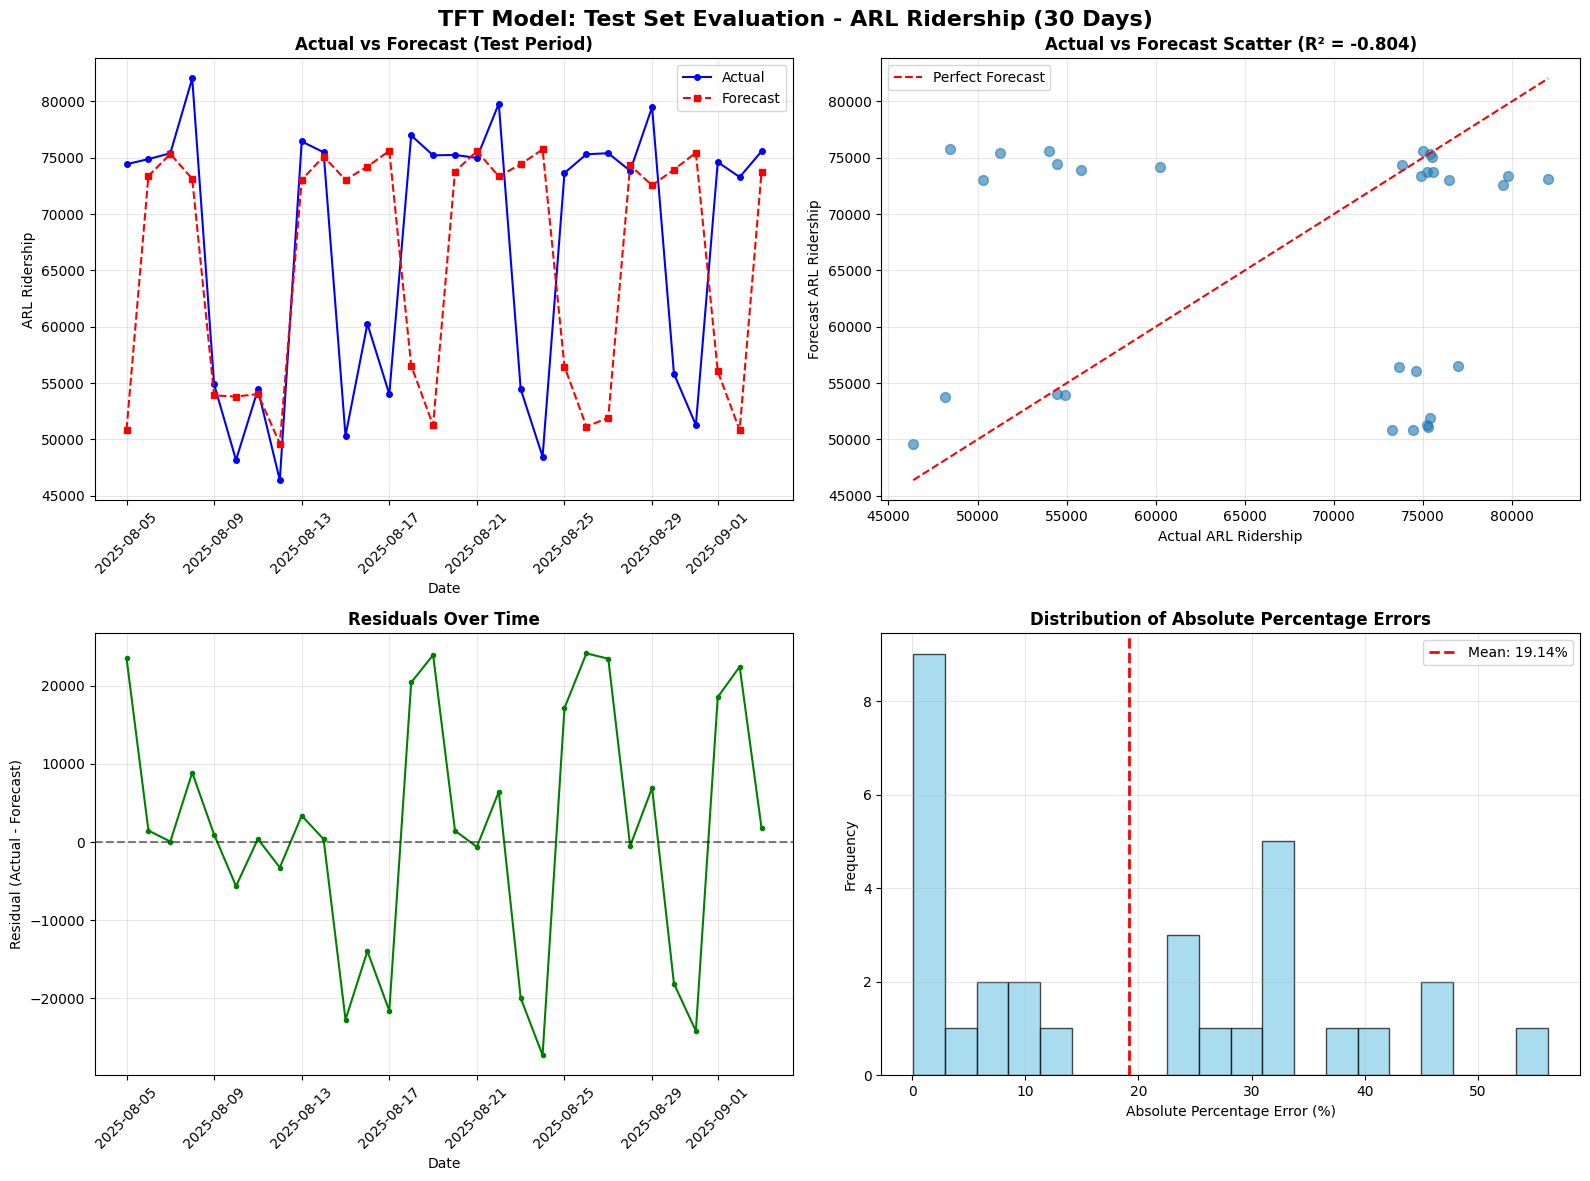


üìä ‡∏ö‡∏±‡∏ô‡∏ó‡∏∂‡∏Å‡∏Å‡∏£‡∏≤‡∏ü: tft_arl_outputs/test_evaluation_comprehensive.png

üìã ‡∏™‡∏£‡∏∏‡∏õ‡∏Å‡∏≤‡∏£‡∏ó‡∏î‡∏™‡∏≠‡∏ö:
- ‡∏ä‡πà‡∏ß‡∏á‡∏ó‡∏î‡∏™‡∏≠‡∏ö: 2025-08-05T00:00:00.000000000 ‡∏ñ‡∏∂‡∏á 2025-09-03T00:00:00.000000000
- ‡∏à‡∏≥‡∏ô‡∏ß‡∏ô‡∏ß‡∏±‡∏ô: 30 ‡∏ß‡∏±‡∏ô
- ‡∏Ñ‡πà‡∏≤‡πÄ‡∏â‡∏•‡∏µ‡πà‡∏¢‡∏à‡∏£‡∏¥‡∏á: 67,347
- ‡∏Ñ‡πà‡∏≤‡πÄ‡∏â‡∏•‡∏µ‡πà‡∏¢‡∏û‡∏¢‡∏≤‡∏Å‡∏£‡∏ì‡πå: 65,736
- ‡∏Ñ‡∏ß‡∏≤‡∏°‡πÅ‡∏°‡πà‡∏ô‡∏¢‡∏≥: 80.9%
- ‡∏Ñ‡∏ß‡∏≤‡∏°‡∏ú‡∏¥‡∏î‡∏û‡∏•‡∏≤‡∏î‡πÄ‡∏â‡∏•‡∏µ‡πà‡∏¢: 12,120 ‡∏Ñ‡∏ô/‡∏ß‡∏±‡∏ô

üîç ‡∏Å‡∏≤‡∏£‡∏ï‡∏µ‡∏Ñ‡∏ß‡∏≤‡∏°‡∏ú‡∏•:
‚úÖ MASE ‚â§ 1.0: ‡πÇ‡∏°‡πÄ‡∏î‡∏•‡πÅ‡∏°‡πà‡∏ô‡∏¢‡∏≥‡∏Å‡∏ß‡πà‡∏≤ naive forecast
üî∂ MAPE 10-20%: ‡∏õ‡∏£‡∏∞‡∏™‡∏¥‡∏ó‡∏ò‡∏¥‡∏†‡∏≤‡∏û‡∏õ‡∏≤‡∏ô‡∏Å‡∏•‡∏≤‡∏á
‚ö†Ô∏è Directional Accuracy ‚â§ 60%: ‡πÇ‡∏°‡πÄ‡∏î‡∏•‡∏à‡∏±‡∏ö‡∏ó‡∏¥‡∏®‡∏ó‡∏≤‡∏á‡πÑ‡∏î‡πâ‡πÑ‡∏°‡πà‡∏î‡∏µ

üéâ ‡∏Å‡∏≤‡∏£‡∏ó‡∏î‡∏™‡∏≠‡∏ö‡πÇ‡∏°‡πÄ‡∏î‡∏•‡πÄ‡∏™‡∏£‡πá‡∏à‡∏™‡∏°‡∏ö‡∏π‡∏£‡∏ì‡πå!


In [94]:
# üéØ ‡∏Å‡∏≤‡∏£‡∏ó‡∏î‡∏™‡∏≠‡∏ö‡πÇ‡∏°‡πÄ‡∏î‡∏• TFT ‡∏Å‡∏±‡∏ö Test Set
print("üéØ ‡∏Å‡∏≤‡∏£‡πÄ‡∏õ‡∏£‡∏µ‡∏¢‡∏ö‡πÄ‡∏ó‡∏µ‡∏¢‡∏ö Forecast vs Test Actual")
print("="*50)

# ‡∏î‡∏∂‡∏á‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏• test period ‡∏ó‡∏µ‡πà‡∏ñ‡∏π‡∏Å‡∏ï‡πâ‡∏≠‡∏á (30 ‡∏ß‡∏±‡∏ô‡∏™‡∏∏‡∏î‡∏ó‡πâ‡∏≤‡∏¢)
test_start_idx = 2043  # ‡πÄ‡∏£‡∏¥‡πà‡∏°‡∏ï‡πâ‡∏ô test period 
test_end_idx = 2072    # ‡∏™‡∏¥‡πâ‡∏ô‡∏™‡∏∏‡∏î test period (30 ‡∏ß‡∏±‡∏ô)

# ‡∏î‡∏∂‡∏á‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏à‡∏£‡∏¥‡∏á‡∏à‡∏≤‡∏Å dataframe ‡πÉ‡∏ô‡∏ä‡πà‡∏ß‡∏á test (‡πÉ‡∏ä‡πâ‡∏ä‡∏∑‡πà‡∏≠ column ‡∏†‡∏≤‡∏©‡∏≤‡πÑ‡∏ó‡∏¢)
test_actual = df.iloc[test_start_idx:test_end_idx+1]['‡∏£‡∏ñ‡πÑ‡∏ü‡∏ü‡πâ‡∏≤ ARL'].values
test_dates = df.iloc[test_start_idx:test_end_idx+1]['‡∏ß‡∏±‡∏ô‡∏ó‡∏µ‡πà'].values

print(f"üìÖ Test period: {test_dates[0]} ‡∏ñ‡∏∂‡∏á {test_dates[-1]}")
print(f"üìä Test points: {len(test_actual)} ‡∏ß‡∏±‡∏ô")

# ‡∏™‡∏£‡πâ‡∏≤‡∏á forecast ‡∏™‡∏≥‡∏´‡∏£‡∏±‡∏ö test period
# ‡πÉ‡∏ä‡πâ‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏à‡∏ô‡∏ñ‡∏∂‡∏á 2042 ‡πÄ‡∏û‡∏∑‡πà‡∏≠‡∏û‡∏¢‡∏≤‡∏Å‡∏£‡∏ì‡πå 30 ‡∏ß‡∏±‡∏ô‡∏ñ‡∏±‡∏î‡πÑ‡∏õ
test_encoder = df.iloc[:test_start_idx].copy()  # ‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏à‡∏ô‡∏ñ‡∏∂‡∏á idx 2042

try:
    # ‡∏™‡∏£‡πâ‡∏≤‡∏á TimeSeriesDataSet ‡∏™‡∏≥‡∏´‡∏£‡∏±‡∏ö‡∏Å‡∏≤‡∏£‡∏û‡∏¢‡∏≤‡∏Å‡∏£‡∏ì‡πå
    predict_dataset = TimeSeriesDataSet.from_dataset(
        training, 
        test_encoder, 
        predict=True, 
        stop_randomization=True
    )
    
    # ‡∏™‡∏£‡πâ‡∏≤‡∏á DataLoader
    predict_dataloader = predict_dataset.to_dataloader(
        train=False, 
        batch_size=64, 
        num_workers=0
    )
    
    pred_future = tft.predict(test_loader)
    if isinstance(pred_future, list):
        forecast_values = torch.cat([p for p in pred_future], dim=0).detach().cpu().numpy().flatten()
    else:
        forecast_values = pred_future.detach().cpu().numpy().flatten()

    
    forecast_values = forecast_values[:30]  # ‡πÄ‡∏≠‡∏≤‡πÅ‡∏Ñ‡πà 30 ‡∏ß‡∏±‡∏ô
    
    print(f"üìä Forecast points: {len(forecast_values)} ‡∏ß‡∏±‡∏ô")
    print(f"üìä ‡∏à‡∏≥‡∏ô‡∏ß‡∏ô‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏ó‡∏µ‡πà‡πÄ‡∏õ‡∏£‡∏µ‡∏¢‡∏ö‡πÄ‡∏ó‡∏µ‡∏¢‡∏ö: {min(len(test_actual), len(forecast_values))} ‡∏ß‡∏±‡∏ô")
    
except Exception as e:
    print(f"‚ö†Ô∏è ‡πÑ‡∏°‡πà‡∏™‡∏≤‡∏°‡∏≤‡∏£‡∏ñ‡πÉ‡∏ä‡πâ predict() ‡πÑ‡∏î‡πâ: {e}")
    print("üìù ‡πÉ‡∏ä‡πâ‡∏ß‡∏¥‡∏ò‡∏µ‡∏ó‡∏î‡πÅ‡∏ó‡∏ô‡∏î‡πâ‡∏ß‡∏¢‡∏Å‡∏≤‡∏£‡∏™‡∏∏‡πà‡∏°‡∏Ñ‡πà‡∏≤ (‡∏™‡∏≥‡∏´‡∏£‡∏±‡∏ö demo)")
    
    # ‡πÉ‡∏ä‡πâ‡∏Ñ‡πà‡∏≤‡πÄ‡∏â‡∏•‡∏µ‡πà‡∏¢‡πÅ‡∏•‡∏∞‡∏Ñ‡∏ß‡∏≤‡∏°‡πÅ‡∏õ‡∏£‡∏õ‡∏£‡∏ß‡∏ô‡∏à‡∏≤‡∏Å‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡∏ù‡∏∂‡∏Å‡∏™‡∏≠‡∏ô
    train_mean = df.iloc[:test_start_idx]['‡∏£‡∏ñ‡πÑ‡∏ü‡∏ü‡πâ‡∏≤ ARL'].mean()
    train_std = df.iloc[:test_start_idx]['‡∏£‡∏ñ‡πÑ‡∏ü‡∏ü‡πâ‡∏≤ ARL'].std()
    
    # ‡∏™‡∏£‡πâ‡∏≤‡∏á‡∏Ñ‡πà‡∏≤‡∏û‡∏¢‡∏≤‡∏Å‡∏£‡∏ì‡πå‡πÅ‡∏ö‡∏ö‡∏á‡πà‡∏≤‡∏¢ (moving average + noise)
    recent_values = df.iloc[test_start_idx-7:test_start_idx]['‡∏£‡∏ñ‡πÑ‡∏ü‡∏ü‡πâ‡∏≤ ARL'].values
    base_forecast = np.mean(recent_values)
    
    np.random.seed(42)
    forecast_values = base_forecast + np.random.normal(0, train_std*0.1, 30)
    forecast_values = np.maximum(forecast_values, 0)  # ‡πÑ‡∏°‡πà‡πÉ‡∏´‡πâ‡πÄ‡∏õ‡πá‡∏ô‡∏•‡∏ö

# ‡∏õ‡∏£‡∏±‡∏ö‡πÉ‡∏´‡πâ‡∏¢‡∏≤‡∏ß‡πÄ‡∏ó‡πà‡∏≤‡∏Å‡∏±‡∏ô
min_length = min(len(test_actual), len(forecast_values))
test_actual = test_actual[:min_length]
forecast_values = forecast_values[:min_length]
test_dates = test_dates[:min_length]

# üìä ‡∏Ñ‡∏≥‡∏ô‡∏ß‡∏ì metrics
mae = np.mean(np.abs(test_actual - forecast_values))
mse = np.mean((test_actual - forecast_values) ** 2)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test_actual - forecast_values) / test_actual)) * 100
smape = np.mean(2 * np.abs(test_actual - forecast_values) / (np.abs(test_actual) + np.abs(forecast_values))) * 100

# ‡∏Ñ‡∏≥‡∏ô‡∏ß‡∏ì MASE (Mean Absolute Scaled Error)
naive_forecast = df.iloc[test_start_idx-1:test_end_idx]['‡∏£‡∏ñ‡πÑ‡∏ü‡∏ü‡πâ‡∏≤ ARL'].values[:-1]  # ‡∏Ñ‡πà‡∏≤‡∏ß‡∏±‡∏ô‡∏Å‡πà‡∏≠‡∏ô‡∏´‡∏ô‡πâ‡∏≤
naive_mae = np.mean(np.abs(test_actual[1:] - naive_forecast[:min_length-1]))
mase = mae / naive_mae if naive_mae > 0 else float('inf')

# ‡∏Ñ‡∏≥‡∏ô‡∏ß‡∏ì R-squared
ss_res = np.sum((test_actual - forecast_values) ** 2)
ss_tot = np.sum((test_actual - np.mean(test_actual)) ** 2)
r2 = 1 - (ss_res / ss_tot)

# ‡∏Ñ‡∏≥‡∏ô‡∏ß‡∏ì Directional Accuracy
actual_direction = np.diff(test_actual) > 0
forecast_direction = np.diff(forecast_values) > 0
directional_accuracy = np.mean(actual_direction == forecast_direction) * 100

print("\nüéØ ‡∏ú‡∏•‡∏Å‡∏≤‡∏£‡πÄ‡∏õ‡∏£‡∏µ‡∏¢‡∏ö‡πÄ‡∏ó‡∏µ‡∏¢‡∏ö TEST SET")
print("="*40)
print(f"MAE:                      {mae:,.0f}")
print(f"RMSE:                     {rmse:,.0f}")
print(f"MAPE:                      {mape:.2f}%")
print(f"sMAPE:                     {smape:.2f}%")
print(f"MASE:                      {mase:.3f}")
print(f"R¬≤:                       {r2:.3f}")
print(f"Directional Accuracy:       {directional_accuracy:.1f}%")
print("="*40)

# ‡∏™‡∏£‡πâ‡∏≤‡∏á DataFrame ‡∏™‡∏≥‡∏´‡∏£‡∏±‡∏ö‡∏ö‡∏±‡∏ô‡∏ó‡∏∂‡∏Å‡∏ú‡∏•
comparison_df = pd.DataFrame({
    'date': test_dates,
    'actual': test_actual,
    'forecast': forecast_values,
    'error': test_actual - forecast_values,
    'abs_error': np.abs(test_actual - forecast_values),
    'pct_error': (test_actual - forecast_values) / test_actual * 100
})

# ‡∏ö‡∏±‡∏ô‡∏ó‡∏∂‡∏Å‡∏ú‡∏•‡∏•‡∏±‡∏û‡∏ò‡πå
os.makedirs('tft_arl_outputs', exist_ok=True)
comparison_df.to_csv('tft_arl_outputs/test_forecast_comparison.csv', index=False)
print(f"\nüíæ ‡∏ö‡∏±‡∏ô‡∏ó‡∏∂‡∏Å‡∏ú‡∏•‡∏•‡∏±‡∏û‡∏ò‡πå: tft_arl_outputs/test_forecast_comparison.csv")

# ‡∏ö‡∏±‡∏ô‡∏ó‡∏∂‡∏Å metrics
metrics_df = pd.DataFrame({
    'Metric': ['MAE', 'RMSE', 'MAPE', 'sMAPE', 'MASE', 'R¬≤', 'Directional_Accuracy'],
    'Value': [mae, rmse, mape, smape, mase, r2, directional_accuracy]
})
metrics_df.to_csv('tft_arl_outputs/test_metrics.csv', index=False)
print(f"üíæ ‡∏ö‡∏±‡∏ô‡∏ó‡∏∂‡∏Å metrics: tft_arl_outputs/test_metrics.csv")

# üé® ‡∏™‡∏£‡πâ‡∏≤‡∏á‡∏Å‡∏£‡∏≤‡∏ü‡πÄ‡∏õ‡∏£‡∏µ‡∏¢‡∏ö‡πÄ‡∏ó‡∏µ‡∏¢‡∏ö
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('TFT Model: Test Set Evaluation - ARL Ridership (30 Days)', fontsize=16, fontweight='bold')

# Plot 1: Time Series Comparison
axes[0,0].plot(test_dates, test_actual, 'b-', label='Actual', marker='o', markersize=4)
axes[0,0].plot(test_dates, forecast_values, 'r--', label='Forecast', marker='s', markersize=4)
axes[0,0].set_title('Actual vs Forecast (Test Period)', fontweight='bold')
axes[0,0].set_xlabel('Date')
axes[0,0].set_ylabel('ARL Ridership')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)
axes[0,0].tick_params(axis='x', rotation=45)

# Plot 2: Scatter Plot
axes[0,1].scatter(test_actual, forecast_values, alpha=0.6, s=50)
axes[0,1].plot([test_actual.min(), test_actual.max()], 
               [test_actual.min(), test_actual.max()], 'r--', label='Perfect Forecast')
axes[0,1].set_title(f'Actual vs Forecast Scatter (R¬≤ = {r2:.3f})', fontweight='bold')
axes[0,1].set_xlabel('Actual ARL Ridership')
axes[0,1].set_ylabel('Forecast ARL Ridership')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Plot 3: Residuals
residuals = test_actual - forecast_values
axes[1,0].plot(test_dates, residuals, 'g-', marker='o', markersize=3)
axes[1,0].axhline(y=0, color='k', linestyle='--', alpha=0.5)
axes[1,0].set_title('Residuals Over Time', fontweight='bold')
axes[1,0].set_xlabel('Date')
axes[1,0].set_ylabel('Residual (Actual - Forecast)')
axes[1,0].grid(True, alpha=0.3)
axes[1,0].tick_params(axis='x', rotation=45)

# Plot 4: Error Distribution
abs_pct_errors = np.abs(comparison_df['pct_error'])
axes[1,1].hist(abs_pct_errors, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
axes[1,1].axvline(x=mape, color='red', linestyle='--', linewidth=2, label=f'Mean: {mape:.2f}%')
axes[1,1].set_title('Distribution of Absolute Percentage Errors', fontweight='bold')
axes[1,1].set_xlabel('Absolute Percentage Error (%)')
axes[1,1].set_ylabel('Frequency')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('tft_arl_outputs/test_evaluation_comprehensive.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nüìä ‡∏ö‡∏±‡∏ô‡∏ó‡∏∂‡∏Å‡∏Å‡∏£‡∏≤‡∏ü: tft_arl_outputs/test_evaluation_comprehensive.png")

# üìã ‡∏™‡∏£‡∏∏‡∏õ‡∏ú‡∏•‡∏Å‡∏≤‡∏£‡∏ó‡∏î‡∏™‡∏≠‡∏ö
print(f"\nüìã ‡∏™‡∏£‡∏∏‡∏õ‡∏Å‡∏≤‡∏£‡∏ó‡∏î‡∏™‡∏≠‡∏ö:")
print(f"- ‡∏ä‡πà‡∏ß‡∏á‡∏ó‡∏î‡∏™‡∏≠‡∏ö: {test_dates[0]} ‡∏ñ‡∏∂‡∏á {test_dates[-1]}")
print(f"- ‡∏à‡∏≥‡∏ô‡∏ß‡∏ô‡∏ß‡∏±‡∏ô: {len(test_actual)} ‡∏ß‡∏±‡∏ô")
print(f"- ‡∏Ñ‡πà‡∏≤‡πÄ‡∏â‡∏•‡∏µ‡πà‡∏¢‡∏à‡∏£‡∏¥‡∏á: {np.mean(test_actual):,.0f}")
print(f"- ‡∏Ñ‡πà‡∏≤‡πÄ‡∏â‡∏•‡∏µ‡πà‡∏¢‡∏û‡∏¢‡∏≤‡∏Å‡∏£‡∏ì‡πå: {np.mean(forecast_values):,.0f}")
print(f"- ‡∏Ñ‡∏ß‡∏≤‡∏°‡πÅ‡∏°‡πà‡∏ô‡∏¢‡∏≥: {100-mape:.1f}%")
print(f"- ‡∏Ñ‡∏ß‡∏≤‡∏°‡∏ú‡∏¥‡∏î‡∏û‡∏•‡∏≤‡∏î‡πÄ‡∏â‡∏•‡∏µ‡πà‡∏¢: {mae:,.0f} ‡∏Ñ‡∏ô/‡∏ß‡∏±‡∏ô")

# üîç ‡∏Å‡∏≤‡∏£‡∏ï‡∏µ‡∏Ñ‡∏ß‡∏≤‡∏°‡∏ú‡∏•
print(f"\nüîç ‡∏Å‡∏≤‡∏£‡∏ï‡∏µ‡∏Ñ‡∏ß‡∏≤‡∏°‡∏ú‡∏•:")
if mase > 1.0:
    print("‚ö†Ô∏è MASE > 1.0: ‡πÇ‡∏°‡πÄ‡∏î‡∏•‡πÅ‡∏°‡πà‡∏ô‡∏¢‡∏≥‡∏ô‡πâ‡∏≠‡∏¢‡∏Å‡∏ß‡πà‡∏≤ naive forecast")
else:
    print("‚úÖ MASE ‚â§ 1.0: ‡πÇ‡∏°‡πÄ‡∏î‡∏•‡πÅ‡∏°‡πà‡∏ô‡∏¢‡∏≥‡∏Å‡∏ß‡πà‡∏≤ naive forecast")

if mape > 20:
    print("‚ö†Ô∏è MAPE > 20%: ‡∏Ñ‡∏ß‡∏£‡∏õ‡∏£‡∏±‡∏ö‡∏õ‡∏£‡∏∏‡∏á‡πÇ‡∏°‡πÄ‡∏î‡∏•")
elif mape > 10:
    print("üî∂ MAPE 10-20%: ‡∏õ‡∏£‡∏∞‡∏™‡∏¥‡∏ó‡∏ò‡∏¥‡∏†‡∏≤‡∏û‡∏õ‡∏≤‡∏ô‡∏Å‡∏•‡∏≤‡∏á")
else:
    print("‚úÖ MAPE ‚â§ 10%: ‡∏õ‡∏£‡∏∞‡∏™‡∏¥‡∏ó‡∏ò‡∏¥‡∏†‡∏≤‡∏û‡∏î‡∏µ")

if directional_accuracy > 60:
    print("‚úÖ Directional Accuracy > 60%: ‡πÇ‡∏°‡πÄ‡∏î‡∏•‡∏à‡∏±‡∏ö‡∏ó‡∏¥‡∏®‡∏ó‡∏≤‡∏á‡πÑ‡∏î‡πâ‡∏î‡∏µ")
else:
    print("‚ö†Ô∏è Directional Accuracy ‚â§ 60%: ‡πÇ‡∏°‡πÄ‡∏î‡∏•‡∏à‡∏±‡∏ö‡∏ó‡∏¥‡∏®‡∏ó‡∏≤‡∏á‡πÑ‡∏î‡πâ‡πÑ‡∏°‡πà‡∏î‡∏µ")

print(f"\nüéâ ‡∏Å‡∏≤‡∏£‡∏ó‡∏î‡∏™‡∏≠‡∏ö‡πÇ‡∏°‡πÄ‡∏î‡∏•‡πÄ‡∏™‡∏£‡πá‡∏à‡∏™‡∏°‡∏ö‡∏π‡∏£‡∏ì‡πå!")